In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from scipy.integrate import quad
from scipy.interpolate import interp1d

ann_arr = load_model('RP_Arrival_time/Arrival_ANN4')
ann_end = load_model('RP_End_time/End_ANN4')
ann_chg = load_model('RP_Change_time/Change_ANN1')

#Section1
ann1 = load_model('RP_Section_1_new3/Section1_new3_ANN_2')
sc1 = pickle.load(open('RP_Section_1_new3/Section1_new3_scaler_ANN_2.pkl', 'rb'))
#Section2
ann2 = load_model('RP_Section_2_new2/Section2_new_ANN_2')
sc2 = pickle.load(open('RP_Section_2_new/Section2_new_scaler_ANN_2.pkl', 'rb'))
#Section3
ann3 = load_model('RP_Section_3_new/Section3_new_ANN_2')
sc3 = pickle.load(open('RP_Section_3_new/Section3_new_scaler_ANN_2.pkl', 'rb'))
#Section4
ann4 = load_model('RP_Section_4_new/Section4_new_ANN_7')
sc4 = pickle.load(open('RP_Section_4_new/Section4_new_scaler_ANN_7.pkl', 'rb'))
#Section5
ann5 = load_model('RP_Section_5_new/Section5_new_ANN_4')
sc5 = pickle.load(open('RP_Section_5_new/Section5_new_scaler_ANN_4.pkl', 'rb'))
#Section6
ann6 = load_model('RP_Section_6_new/Section6_new_ANN_2')
sc6 = pickle.load(open('RP_Section_6_new/Section6_new_scaler_ANN_2.pkl', 'rb'))

D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\Anaconda3\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at you

In [5]:
def boundary_search(file_path,Mass, Distance, Angle):
    start_time_num = None
    end_time_num = None
    
    # Load the Excel file
    df1 = pd.read_excel(file_path)
    # Filter the DataFrame to keep only rows with matching Mass and Distance
    df_filtered1 = df1[(df1['Mass'] == Mass) & (df1['Standoff distance'] == Distance)]

    # If the filtered DataFrame is empty, raise an error or return a default value
    if df_filtered1.empty:
        raise ValueError(f"No rows found matching the specified Mass {Mass}, Distance {Distance}, Angle {Angle}, Filename {file_name} and Filepath {file_path}.")
    
    # Sort the filtered DataFrame by Time in ascending order
    df_sorted1 = df_filtered1.sort_values(by='Time', ascending=True)
    X = df_sorted1['Time'].values
    y = df_sorted1['Pressure'].values+101.25
    X2 = X.to_numpy()
    y2 = y.to_numpy()
    
    start_index = np.argmax(y)
    start_time_num = X2[start_index]
    zero_index1 = next((i for i, val in enumerate(y2[start_index:], start=0) if val <= 101.25), None)
    if isinstance (zero_index1, int):
       zero_index1 = zero_index1 + start_index
       min_index = np.argmin(y2[zero_index1:])+zero_index1
       zero_index2 = next((i for i, val in enumerate(y2[min_index:], start=0) if val < 101.25), None)
       if isinstance (zero_index2, int):
           end_index = zero_index2 + min_index
           end_time_num = X2[end_index]
       else:
           end_time_num = X2[-1]
    else:
        print('zero_index1 error')
    
    arr = np.array ([[Mass,Distance, Angle]])
    arrival_time = ann_arr.predict(arr)
    end_time = ann_end.predict(arr)
    start_time_ann = float(arrival_time[0][0])
    end_time_ann = float(end_time[0][0])
    start_time_overall = min(start_time_num, start_time_ann)
    end_time_overall = max(end_time_num, end_time_ann)
    end_time_overall = min(end_time_overall, X[-1])
    
    X1,y1 = predict_ann(Distance, Mass, Angle, start_time_overall, end_time_overall,sc, ann, interval=0.01)
    ann_auc, ann_auc_series, ann_time, ann_pressure = auc_cal(X1,y1, start_time_overall, end_time_overall)
    num_auc, num_auc_series, num_time, num_pressure = auc_cal(X2,y2, start_time_overall, end_time_overall)
    
    return start_time_overall, end_time_overall

def auc_cal(X,y, start_time, end_time):
    dataset = pd.DataFrame(X, columns=['Time'])
    dataset['Pressure'] = y
    filtered_data = dataset[(dataset['Time'] >= start_time) & (dataset['Time'] <= end_time)]
    # Extract time and pressure values
    time_values = filtered_data['Time'].values
    pressure_values = filtered_data['Pressure'].values
    
    # Integrate using the trapezoidal rule
    integration_result = np.trapz(pressure_values, time_values)
    auc_series = np.cumsum(np.gradient(time_values) * pressure_values)
    
    return integration_result, auc_series, time_values, pressure_values

# Mapping logic based on Section
def get_scaler_and_model(section):
    sc = scalers.get(section)
    ann = models.get(section)

    if sc is None or ann is None:
        raise ValueError(f"Invalid Section: {section}. Valid sections are 1 to 6.")

    return sc, ann

# Perform trapezoidal rule integration
def integrate_with_TR(time, y):
    cumulative_integration = np.cumsum(np.gradient(time) * y)
    
    return cumulative_integration

# Function to perform integration
def perform_integration(file_path, Mass, Distance, Angle, file_name):
    # Load the Excel file
    df = pd.read_excel(file_path)
    # Filter the DataFrame to keep only rows with matching Mass and Distance
    df_filtered = df[(df['Mass'] == Mass) & (df['Standoff distance'] == Distance)]

    # If the filtered DataFrame is empty, raise an error or return a default value
    if df_filtered.empty:
        raise ValueError(f"No rows found matching the specified Mass {Mass}, Distance {Distance}, Angle {Angle}, Filename {file_name} and Filepath {file_path}.")
    
    # Sort the filtered DataFrame by Time in ascending order
    df_sorted = df_filtered.sort_values(by='Time', ascending=True)
    
    # Extract time and pressure values
    time_num = df_sorted['Time'].values
    y_num = df_sorted['Pressure'].values+101.25
    cumulative_integration = integrate_with_TR(time_num, y_num)
    # Find the maximum time value
    max_time = np.max(time_num)
    
    return max_time, cumulative_integration[-1]

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values
    
def p_fluctuation(d_set, sc, ann):
    d_set[:,0:4] = sc.transform(d_set[:,0:4])
    p_f = ann.predict(d_set)
    return p_f

# Define the function to generate time_ann and y_ann
def predict_ann(Distance, Mass, Angle, start_time, termination_time,sc, ann, interval=0.01):

    arr = np.array ([[Mass,Distance, Angle]])
    arrival_time = ann_arr.predict(arr)
    end_time = ann_end.predict(arr)
    change_time = ann_chg.predict(arr)
    #print ("1",arrival_time,end_time, change_time)
    
    if termination_time < arrival_time:
        start = start_time
        end = termination_time
        values1 = stable_state(start, end, interval)
        arrival_time = 0
        end_time = 0
    
    else:
        start = start_time
        end = arrival_time
        values1 = stable_state(start, end, interval)
        
        if termination_time < end_time:
            end_time = termination_time
            
        else:
            start = end_time
            end = termination_time
            values3 = stable_state(start, end, interval)
    
    t2= np.arange(arrival_time, end_time + interval, interval)
    t2 = t2.reshape(len(t2),1)
    
    if t2[0] < change_time:
        ph2 = np.array([[0, 1]])
    else:
        ph2 = np.array([[1, 0]])
        
    positive = np.array([0, 1])
    negative= np.array([1, 0])
    
    for time in t2[1:]:
        if time < change_time:
            ph2=np.vstack((ph2,positive))
        else:
            ph2=np.vstack((ph2,negative))
            
    m2 = np.repeat(Mass, len(t2)).reshape(len(t2),1)
    d2 = np.repeat(Distance, len(t2)).reshape(len(t2),1)
    a2 = np.repeat(Angle, len(t2)).reshape(len(t2),1)
    d_set = np.concatenate ((m2, d2, a2, t2, ph2), axis = 1)
    p2 = p_fluctuation(d_set,sc,ann)
    p2 = p2.reshape((-1, 1))
    values2 = np.concatenate ((t2, p2), axis = 1)
    
    
    if 'values2' in locals():
        ml_model = np.concatenate((values1, values2), axis=0)
        if 'values3' in locals():
            ml_model = np.concatenate((ml_model, values3), axis=0)
    else:
        ml_model = values1
    
    X = ml_model[:,0]
    y = ml_model[:,1]
    y = y + 101.25
    
    return X,y


In [39]:
## Define the root directory and section
root_dir = Path("G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_new")
Section = 6

scalers = {1: sc1, 2: sc2, 3: sc3, 4: sc4, 5: sc5, 6: sc6}
models = {1: ann1, 2: ann2, 3: ann3, 4: ann4, 5: ann5, 6: ann6}
# Mapping of file names to angles
angle_mapping1 = {'1.xlsx': 0, '2.xlsx': 15, '3.xlsx': 30, '4.xlsx': 45}
angle_mapping2 = {'1': 0, '2': 15, '3': 30, '4': 45}

# List to store file paths and corresponding metadata
file_data = []

sc, ann = get_scaler_and_model(Section)

# Traverse through all directories and subdirectories
for file_path in root_dir.rglob('*.xlsx'):
    # Extract the parent directory name
    parent_dir = file_path.parent.name
    
    # Parse distance and mass from the directory name
    distance, rest = parent_dir.split('m', 1)
    mass = rest.split('kg', 1)[0]
    
    # Extract the file name without extension and map to angle
    file_name = file_path.stem
    angle = angle_mapping1.get(file_name, None)  # Use None if file name is not in the mapping
    
    if angle is None:
        angle = angle_mapping2.get(file_name, None)
    
    # Append the data
    file_data.append({
        'path': str(file_path),
        'distance': float(distance),
        'mass': float(mass),
        'angle': angle,
        'file name': file_name,
        'sc': sc,
        'ann': ann
    })

# Convert the data to a DataFrame
sampled_files = pd.DataFrame(file_data)

# Randomly select 30% of the files
#sampled_files = sampled_files.sample(frac=0.3, random_state=40)
print (sampled_files)

sampled_files[['termination_time', 'num_integration']] = sampled_files.apply(lambda row: pd.Series(boundary_search(row['path'], row['mass'], row['distance'], row ['angle'])), axis=1)

# Apply integration to the sampled files and add a new column
sampled_files[['termination_time', 'num_integration']] = sampled_files.apply(lambda row: pd.Series(perform_integration(row['path'], row['mass'], row['distance'], row['angle'], row['file name'])), axis=1)
# Apply ANN-based model to sampled files
sampled_files[['ml_integration', 'termination_time_ann']] = sampled_files.apply(
    lambda row: pd.Series(integrate_ann(row['distance'], row['mass'], row ['angle'], row['termination_time'], row['sc'], row['ann'])), 
    axis=1)

# Print the updated sampled files DataFrame
print(sampled_files)

# Optionally, save the updated DataFrame to a CSV for later use
sampled_files.to_excel(f'RP_TR_integration_Section{Section}n.xlsx', index=False)

                                                  path  distance  mass  angle  \
0    G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      25.0   0.5      0   
1    G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      25.0   0.5     15   
2    G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      25.0   0.5     30   
3    G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      25.0   0.5     45   
4    G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      25.0   2.5      0   
..                                                 ...       ...   ...    ...   
296  G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      30.0  34.5     45   
297  G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      30.0  35.0      0   
298  G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      30.0  35.0     15   
299  G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      30.0  35.0     30   
300  G:\Chamodi\LSDYNA3D\RP_TH_models\RP_Section_6_...      30.0  35.0     45   

    file name              

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
Section = 6

file_path = f'RP_TR_integration_Section{Section}n.xlsx'
data = pd.read_excel(file_path, sheet_name= 'Sheet1')

data = data.sample(n=30, random_state=40)

# Extract the numerical and ML model integration values
numerical_values = data['num_integration']
ml_model_values = data['ml_integration']

# Calculate MAE
mae = mean_absolute_error(numerical_values, ml_model_values)

# Calculate RMSE
rmse = mean_squared_error(numerical_values, ml_model_values, squared=False)

# Calculate R2
r2 = r2_score(numerical_values, ml_model_values)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Coefficient of Determination (R^2): {r2:.4f}")

Mean Absolute Error (MAE): 762.9751
Root Mean Squared Error (RMSE): 870.1442
Coefficient of Determination (R^2): 0.8841


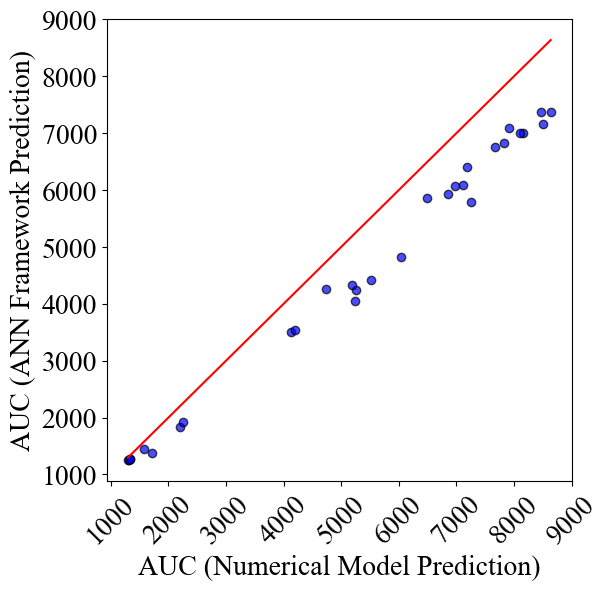

In [69]:
import matplotlib.pyplot as plt

# Scatter plot of numerical_values vs ml_model_values
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([min(numerical_values), max(numerical_values)], 
         [min(numerical_values), max(numerical_values)], 
         color='red', linestyle='-')
plt.scatter(numerical_values, ml_model_values, alpha=0.7, color='blue', edgecolors='k')

plt.xlabel("AUC (Numerical Model Prediction)",fontsize = 20)
plt.ylabel("AUC (ANN Framework Prediction)",fontsize = 20)
plt.xticks(fontsize = 20, rotation = 45)
plt.yticks(fontsize = 20)
plt.savefig(f'RP_Integration_Section_{Section}.png', dpi=150, bbox_inches='tight')
plt.show()